# Tratamiento de Datos

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 50)

print("✅ Todas las librerías instaladas correctamente!")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"LightGBM: {lgb.__version__}")
print(f"XGBoost: {xgb.__version__}")


✅ Todas las librerías instaladas correctamente!
NumPy: 2.3.5
Pandas: 2.3.3
LightGBM: 4.6.0
XGBoost: 3.1.2


In [7]:
# Load data
from pathlib import Path

DATA_DIR = Path("../data/raw")

train_values = pd.read_csv(DATA_DIR / "train_values.csv", index_col="building_id")
train_labels = pd.read_csv(DATA_DIR / "train_labels.csv", index_col="building_id")
test_values = pd.read_csv(DATA_DIR / "test_values.csv", index_col="building_id")

print(f"✅ Datos cargados!")
print(f"Train: {train_values.shape}")
print(f"Test: {test_values.shape}")


✅ Datos cargados!
Train: (260601, 38)
Test: (86868, 38)


In [8]:
# Ver primeras filas
train_values.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


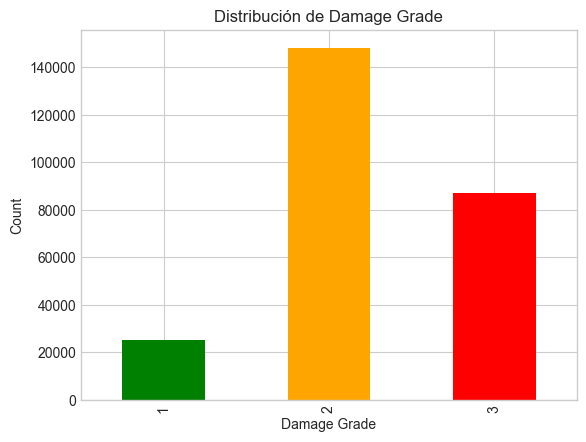

damage_grade
2    0.568912
3    0.334680
1    0.096408
Name: proportion, dtype: float64


In [9]:
# Distribución de daño
train_labels.damage_grade.value_counts().sort_index().plot(
    kind='bar', 
    title='Distribución de Damage Grade',
    color=['green', 'orange', 'red']
)
plt.xlabel('Damage Grade')
plt.ylabel('Count')
plt.show()

print(train_labels.damage_grade.value_counts(normalize=True))

In [10]:
# Información general
print("="*50)
print("INFORMACIÓN DEL DATASET")
print("="*50)
print(f"\nColumnas numéricas: {train_values.select_dtypes(include=['int64', 'float64']).columns.tolist()}")
print(f"\nColumnas categóricas: {train_values.select_dtypes(include=['object']).columns.tolist()}")
print(f"\nValores nulos:\n{train_values.isnull().sum().sum()}")


INFORMACIÓN DEL DATASET

Columnas numéricas: ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 'count_families', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']

Columnas categóricas: ['land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_typ

In [11]:
# Ver valores únicos de cada variable categórica
categorical_cols = train_values.select_dtypes(include=['object']).columns

for col in categorical_cols:
    print(f"\n{col}:")
    print(train_values[col].value_counts())
    print("-" * 40)


land_surface_condition:
land_surface_condition
t    216757
n     35528
o      8316
Name: count, dtype: int64
----------------------------------------

foundation_type:
foundation_type
r    219196
w     15118
u     14260
i     10579
h      1448
Name: count, dtype: int64
----------------------------------------

roof_type:
roof_type
n    182842
q     61576
x     16183
Name: count, dtype: int64
----------------------------------------

ground_floor_type:
ground_floor_type
f    209619
x     24877
v     24593
z      1004
m       508
Name: count, dtype: int64
----------------------------------------

other_floor_type:
other_floor_type
q    165282
x     43448
j     39843
s     12028
Name: count, dtype: int64
----------------------------------------

position:
position
s    202090
t     42896
j     13282
o      2333
Name: count, dtype: int64
----------------------------------------

plan_configuration:
plan_configuration
d    250072
q      5692
u      3649
s       346
c       325
a       252


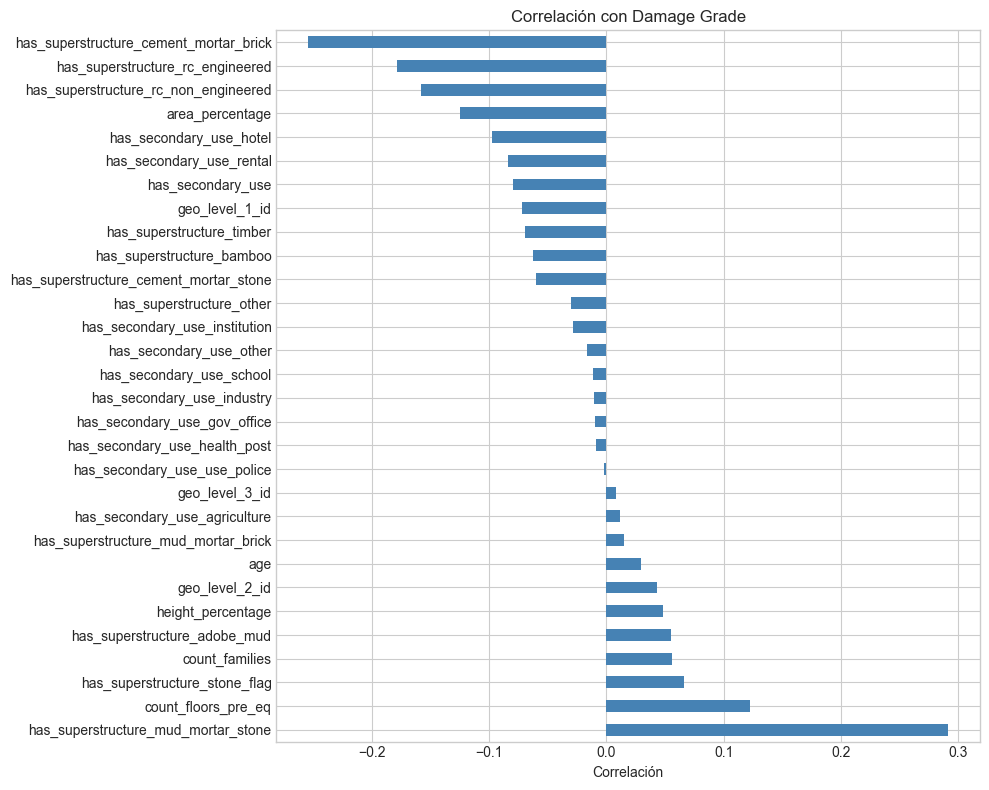

In [12]:
# Combinar features con labels
train = train_values.join(train_labels)

# Ver correlación de variables numéricas con damage_grade
numeric_cols = train_values.select_dtypes(include=['int64', 'float64']).columns

correlations = train[numeric_cols].corrwith(train['damage_grade']).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
correlations.plot(kind='barh', color='steelblue')
plt.title('Correlación con Damage Grade')
plt.xlabel('Correlación')
plt.tight_layout()
plt.show()


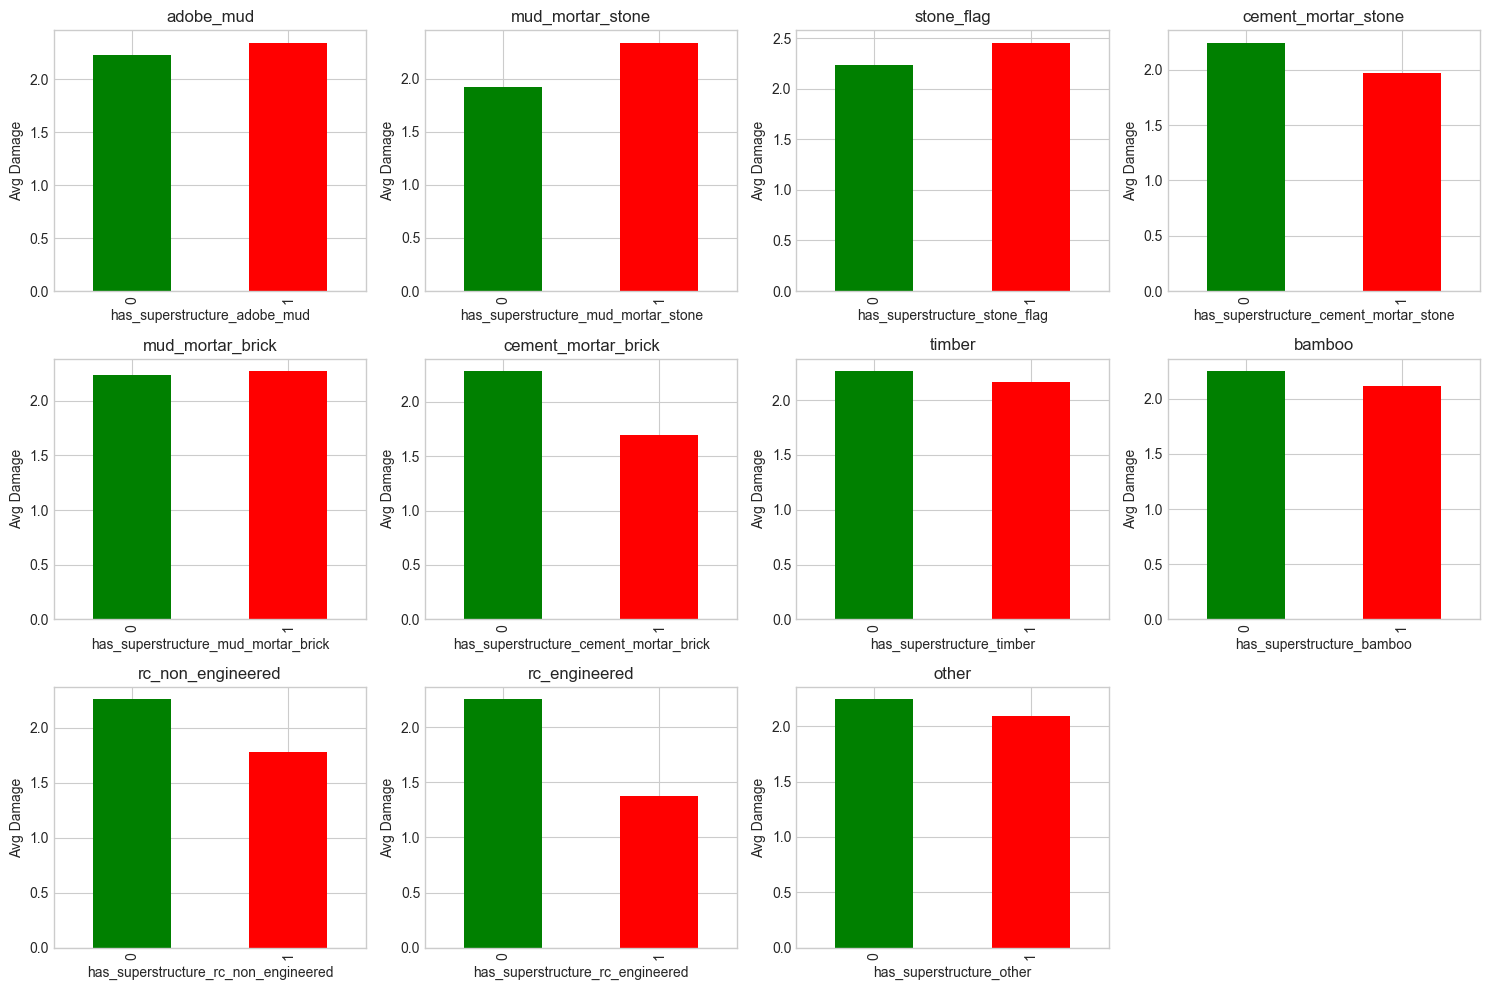

In [13]:
# Relación entre tipo de superstructure y daño
superstructure_cols = [col for col in train.columns if 'has_superstructure' in col]

fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(superstructure_cols):
    train.groupby(col)['damage_grade'].mean().plot(
        kind='bar', 
        ax=axes[i], 
        title=col.replace('has_superstructure_', ''),
        color=['green', 'red']
    )
    axes[i].set_ylabel('Avg Damage')

# Ocultar subplot vacío
axes[-1].set_visible(False)
plt.tight_layout()
plt.show()


**Materiales que aumentan el daño:**

- Mortero de barro y piedra
- Adobe
- Flagstone
- Ladrillo y mortero de barro

**Materiales que reducen el daño:**

- Hormigón armado (con ingeniería)
- Hormigón armado (sin ingeniería)
- Ladrillo y mortero de cemento
- Piedra y mortero de cemento
- Bambú
- Madera

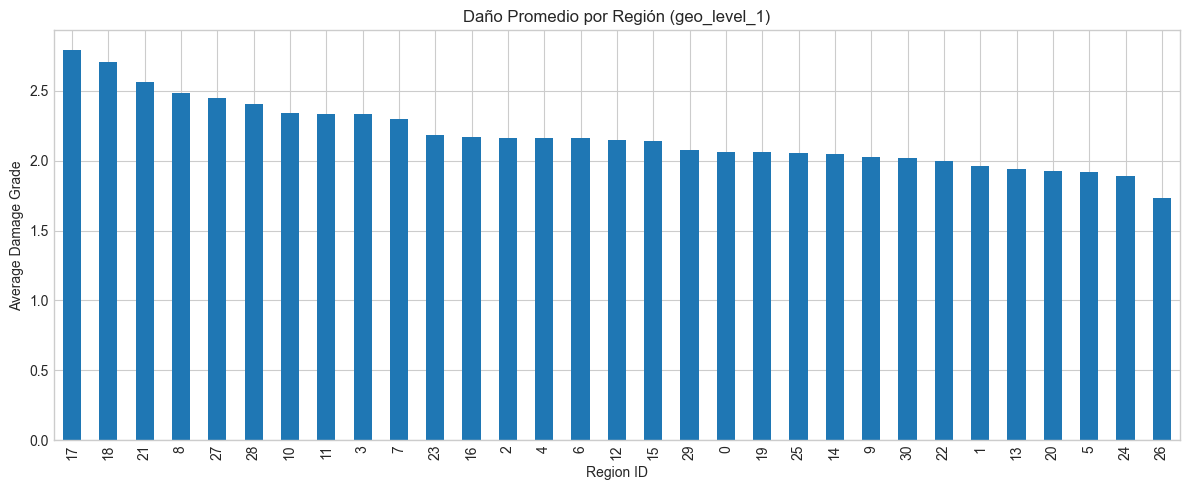


📍 Regiones con más daño:
                avg_damage  n_buildings
geo_level_1_id                         
17                2.794480        21813
18                2.708373         3189
21                2.563369        14889
8                 2.485273        19080
27                2.446457        12532
28                2.407547          265
10                2.341954        22079
11                2.337713         8220
3                 2.331565         7540
7                 2.297726        18994


In [14]:
# Daño promedio por región (geo_level_1)
damage_by_region = train.groupby('geo_level_1_id')['damage_grade'].agg(['mean', 'count'])
damage_by_region.columns = ['avg_damage', 'n_buildings']

plt.figure(figsize=(12, 5))
damage_by_region['avg_damage'].sort_values(ascending=False).plot(kind='bar')
plt.title('Daño Promedio por Región (geo_level_1)')
plt.xlabel('Region ID')
plt.ylabel('Average Damage Grade')
plt.tight_layout()
plt.show()

print("\n📍 Regiones con más daño:")
print(damage_by_region.sort_values('avg_damage', ascending=False).head(10))